In [1]:
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
from IPython.core.display import HTML

import deepdoctection as dd

## Sample

Take an image (e.g. .png, .jpg, ...). If you take the example below you'll maybe need to change ```image_path```.

TypeError: Image data of dtype object cannot be converted to float

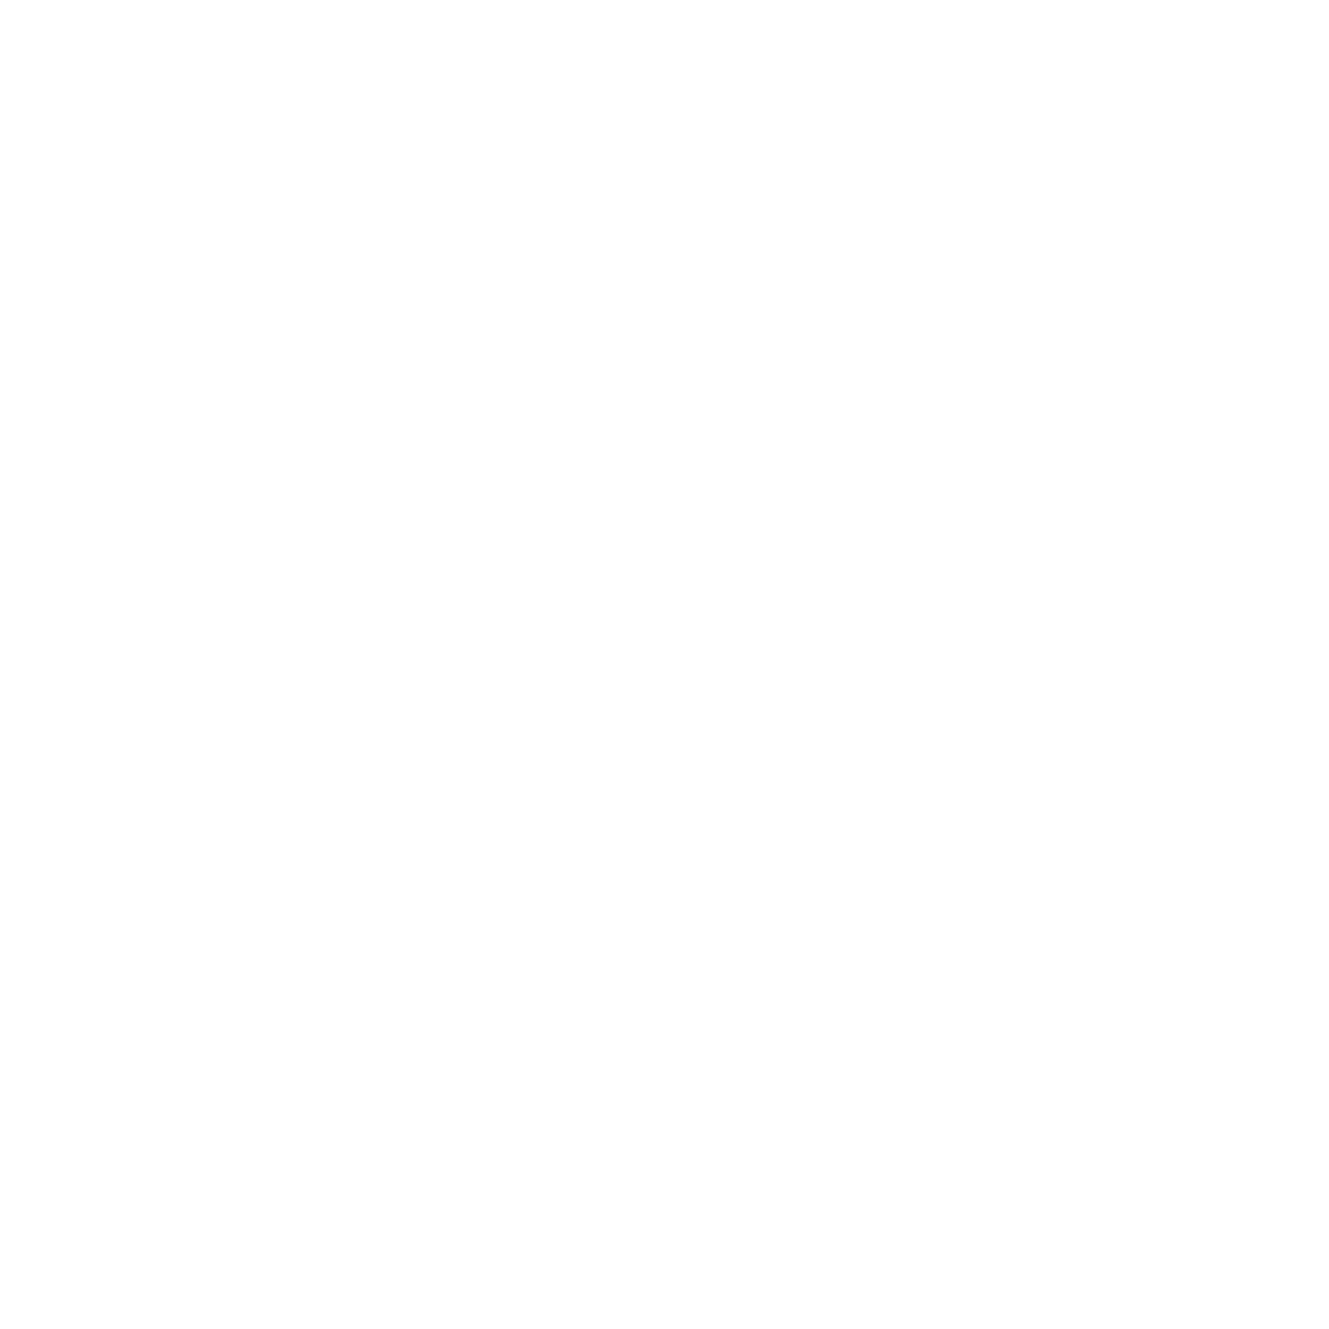

In [2]:
image_path = Path.cwd() / "ds.png"
image = cv2.imread(image_path.as_posix())
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(image)

## Analyzer

Next, we instantiate the **deep**doctection analyzer. The analyzer is an example of a pipeline that can be built depending on the problem you want to tackle. This particular pipeline is built from various building blocks. We will come back to this later. 

Because the document is german we will be using Tesseract's model trained on german text (config_overwrite=["LANGUAGE='deu'"]). If you have a document in a different language choose one by entering its [LangCode](https://tesseract-ocr.github.io/tessdoc/Data-Files-in-different-versions.html). Here are some examples: `fra`, `nld`, `chi_sim`, `ces`, `fas`, `ell`, `mkd`, `ron`, `hye`, `kat`. 

This will give you, depending on your language, much better results than using the default english model.

In [3]:
analyzer = dd.get_dd_analyzer(config_overwrite=["LANGUAGE='Vietnamese'"])

/home/giang/anaconda3/envs/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[0926 08:51.11 @dd.py:379]  INF  Config: 
 {'DEVICE': 'cpu',
 'LANGUAGE': 'Vietnamese',
 'LIB': 'PT',
 'OCR': {'CONFIG': {'TESSERACT': 'dd/conf_tesseract.yaml'},
         'USE_DOCTR': False,
         'USE_TESSERACT': True,
         'USE_TEXTRACT': False,
         'WEIGHTS': {'DOCTR_RECOGNITION': {'PT': 'doctr/crnn_vgg16_bn/pt/crnn_vgg16_bn-9762b0b0.pt',
                                           'TF': 'doctr/crnn_vgg16_bn/tf/crnn_vgg16_bn-76b7f2c6.zip'},
                     'DOCTR_WORD': {'PT': 'doctr/db_resnet50/pt/db_resnet50-ac60cadc.pt',
                                    'TF': 'doctr/db_resnet50/tf/db_resnet50-adcafc63.zip'}}},
 'PT': {'CELL': {'FILTER': None,
                 'WEIGHTS': 'cell/d2_model_1849999_cell_i

## Analyze methods

Once all models have been loaded, we can process single pages, multi page PDF-documents or `Dataflow`s. Leaving `Dataflow`s aside for now, you can either set `path='path/to/dir'` if you have a folder of images or `path='path/to/my/doc.pdf'` if you have a pdf document. 

You will receive an error if your path points to a single image. Processing images requires to pass the path to the base image directory.

In [4]:
path = Path.cwd() / "images"

df = analyzer.analyze(path=path)
df.reset_state()  # This method must be called just before starting the iteration. It is part of the API.

|          |1/?[00:00<00:00,2734.23it/s]


You can see, when activating the cell, that not much has happened yet. The reason is that `analyze` is a [generator function](https://wiki.python.org/moin/Generators). It does not return instantly any results. Instead it returns a `Dataflow`. 

A `Dataflow` is an object to create iterators for data loading and data processing. You can traverse through all the values of the `Dataflow` simply by using a `for`-loop or the `next` function. Let's go!  

In [5]:
doc=iter(df)
page = next(doc)

[0926 08:51.24 @doctectionpipe.py:84]  INF  Processing ds.png
/home/giang/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1501: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return forward_call(*args, **kwargs)
[0926 08:51.29 @context.py:126]  INF  ImageLayoutService total: 4.4298 sec.
[0926 08:51.34 @context.py:126]  INF  SubImageLayoutService total: 5.0369 sec.
[0926 08:51.38 @context.py:126]  INF  SubImageLayoutService total: 4.2443 sec.
[0926 08:51.38 @context.py:126]  INF  TableSegmentationService total: 0.02 sec.
[0926 08:51.38 @maputils.py:89]  WRN  MappingContextManager error. Will filter annotation
[0926 08:51.38 @maputils.py:89]  WRN  MappingContextManager error. Will filter annotation
[0926 08:51.38 @maputils.py:89]  WRN  MappingContextManager error. Will filter annotation
[0926 08:51.38 @maputils.py:89]  WRN  MappingContextManage

## Page

Let's see what we got back. For each iteration we receive a `Page` object. This object stores all informations that have been collected from a page document when running through the pipeline. 

In [6]:
type(page)

deepdoctection.datapoint.view.Page

Let's also have a look on some top level information. 

In [7]:
print(f" height: {page.height} \n width: {page.width} \n file_name: {page.file_name} \n document_id: {page.document_id} \n image_id: {page.image_id}\n")

 height: 1654.0 
 width: 2338.0 
 file_name: ds.png 
 document_id: 7f8fcf14-cdb1-361c-9c61-ea96825230d9 
 image_id: 7f8fcf14-cdb1-361c-9c61-ea96825230d9



`document_id` and `image_id` are the same. The reason is because we only process a single image. The naming convention silently assumes that we deal with a one page document. Once we process multi page PDFs `document_id` and `image_id` differ.

With `get_attribute_names()` you get a list of all attributes. 

In [8]:
page.get_attribute_names()

{'chunks',
 'document_id',
 <PageType.document_type>,
 'file_name',
 <PageType.language>,
 'layouts',
 'location',
 'page_number',
 'tables',
 'text',
 'words'}

In [9]:
page.document_type, page.language

(None, None)

`page.document_type` and `page.language` both return None. The reason is that the analyzer has no component for predicting a document type or a language.

You can easily build a custom analyzer/pipeline containing a document classifier, though. Check this [notebook](Using_LayoutLM_for_sequence_classification.ipynb) for further information.

## Layout segments

We can visualize detected layout segments. If you set `interactive=True` a viewer will pop up. Use `+` and `-` to zoom out/in. Use `q` to close the page.

Alternatively, you can visualize the output with matplotlib.

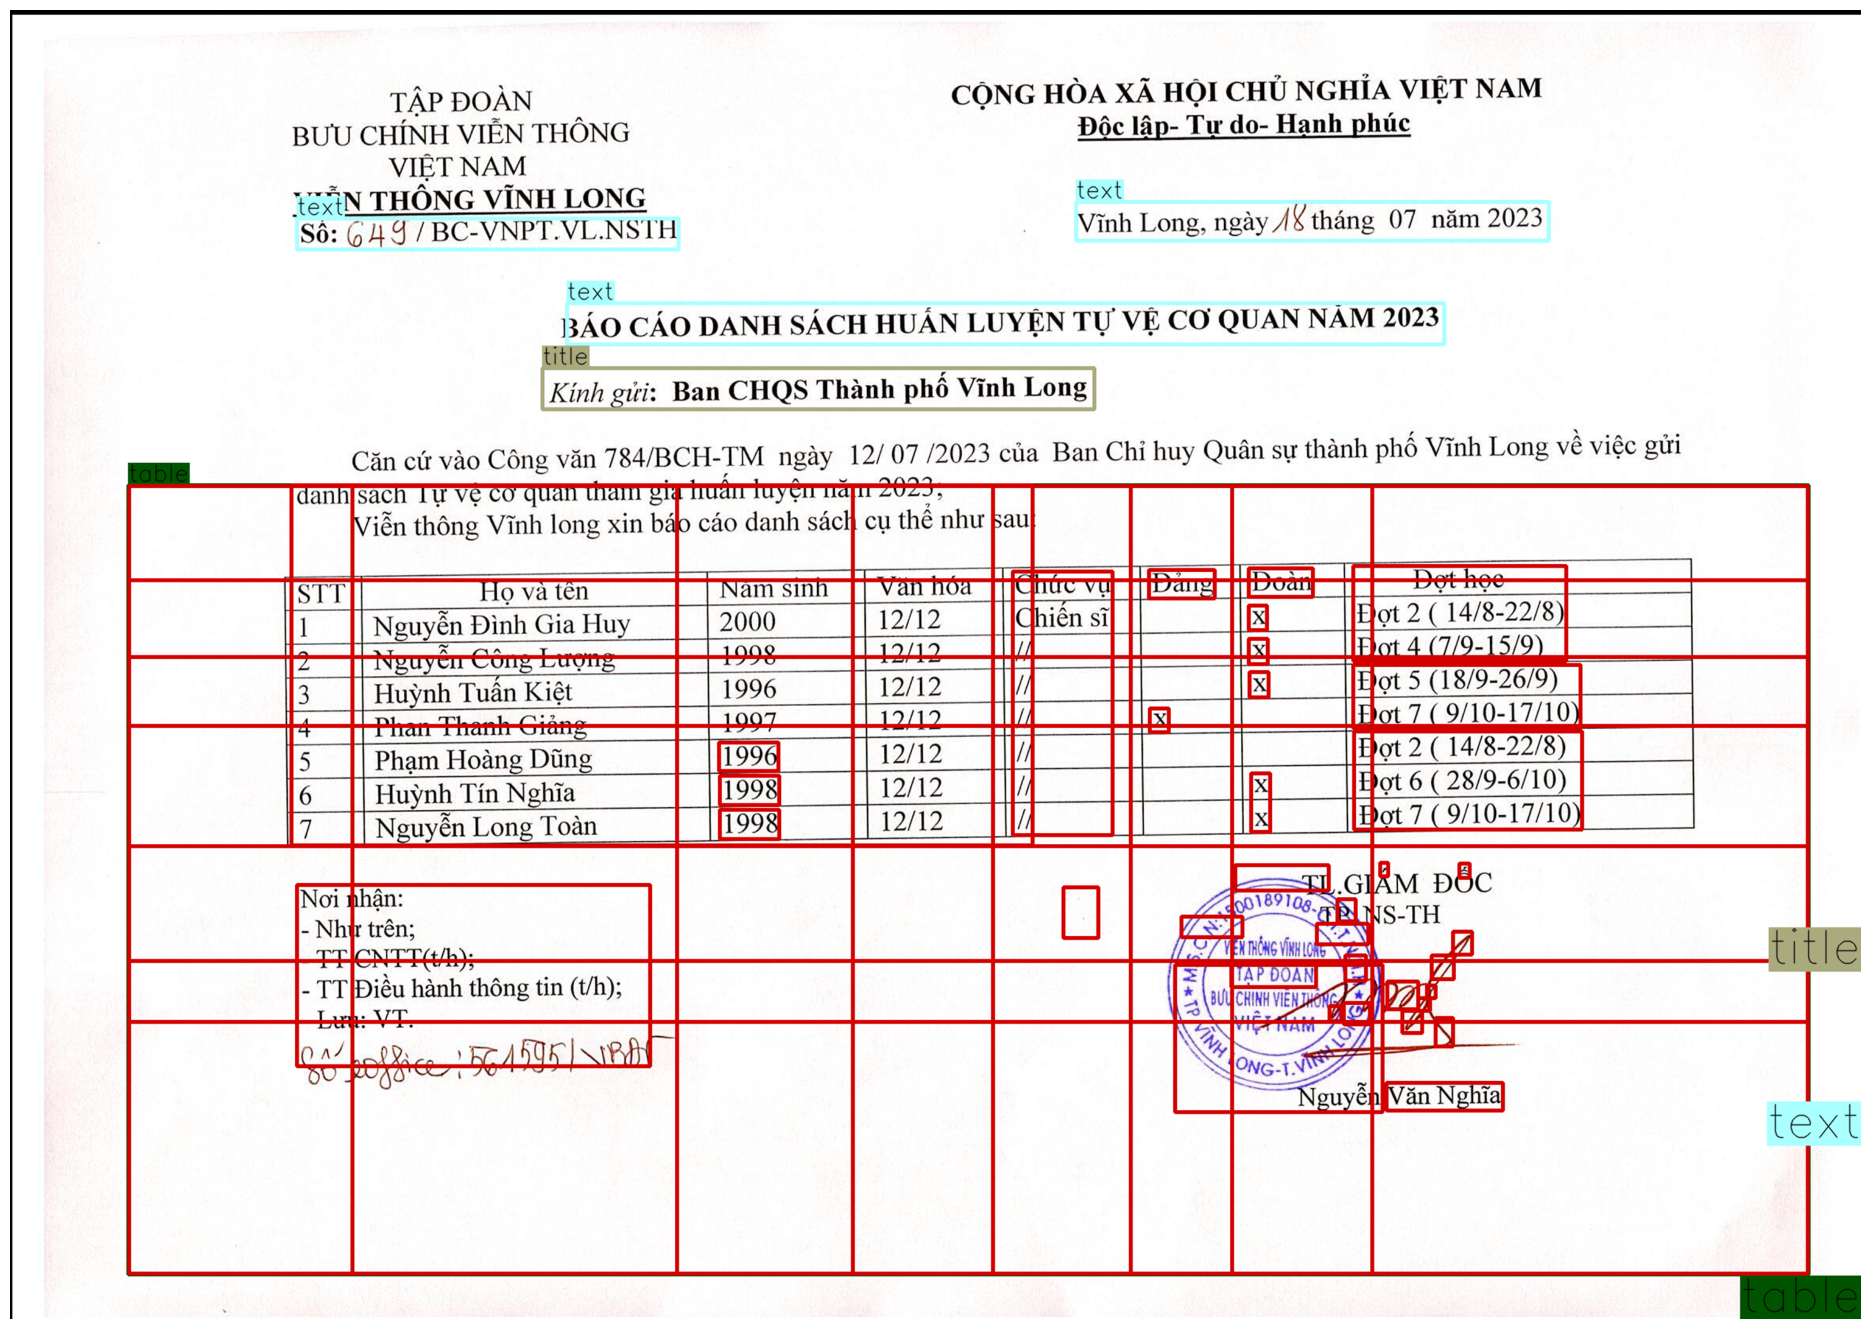

In [10]:
image = page.viz()
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(image)

Let's have a look at other attributes. We can use the `text` property to get the content of the document. You will notice that the table is not included. You can therefore filter tables from the other content. In fact you can even filter on every layout segment.

In [11]:
print(page.text)

Kính gửi: Ban CHQS Thành phô Vĩnh Long
2023 BÁO CÁO DANH SÁCH HUÁN LUYỆN TỰ VỆ CƠ QUAN NĂM
Vĩnh Long, ngày /4 tháng 07 năm 2023
Số: 013 / BC-VNPT.VL.NSTH



You can get the individual layout segments like `text`, `title`, `list` or `figure`. 

In [12]:
for layout in page.layouts:
    if layout.category_name=="title":
        print(f"Title: {layout.text}")

Title: Kính gửi: Ban CHQS Thành phô Vĩnh Long


You can also get the layout segments from the `chunks` attribute. The output is a list of tuples with the most essential meta data for each layout segment, namely: `document_id, image_id, page_number, annotation_id, reading_order, category_name` and `text`.

In [14]:
page.chunks[0]

IndexError: list index out of range

Tables cannot be retrieved from `page.layouts`. They have a special `page.tables` which is a python list of table objects. Obviously, only one table has been detected. 

In [13]:
len(page.tables)

1

Let's have a closer look at the table. 

In [14]:
table = page.tables[0]
table.get_attribute_names()

{'bbox',
 'cells',
 'columns',
 'csv',
 <TableType.html>,
 <TableType.item>,
 <TableType.max_col_span>,
 <TableType.max_row_span>,
 <TableType.number_of_columns>,
 <TableType.number_of_rows>,
 <Relationships.reading_order>,
 'rows',
 'text',
 'words'}

In [15]:
print(f" number of rows: {table.number_of_rows} \n number of columns: {table.number_of_columns} \n reading order: {table.reading_order}")

 number of rows: 7 
 number of columns: 8 
 reading order: None


There is no reading order. The reason is that we have excluded tables from having a specific reading order position because we want to separate tables from the narrative text. This is pure customizing and we can change the customizing so that tables are part of the narrative text. We will come to this later.

You can get an html, csv or text version of your table. Use `table.csv` to load the table into a Pandas Dataframe.

In [16]:
HTML(table.html)

[0926 08:52.41 @view.py:271]  WRN  html construction not possible due to ValueError in: 6755bd8a-fbdd-3a9e-b7df-dd41ecdcf65b
[0926 08:52.41 @view.py:271]  WRN  html construction not possible due to ValueError in: e069692b-ed4d-3b77-a31e-657ed1f0f1d4
[0926 08:52.41 @view.py:271]  WRN  html construction not possible due to ValueError in: f523061e-51fc-3fe1-a74f-0c0e8f683848
[0926 08:52.41 @view.py:271]  WRN  html construction not possible due to ValueError in: 200387b4-014b-380b-ac82-130cc9673154
[0926 08:52.41 @view.py:271]  WRN  html construction not possible due to ValueError in: cd0ca3b9-3cdf-3da6-bcd3-799df7386465
[0926 08:52.41 @view.py:271]  WRN  html construction not possible due to ValueError in: bcd4fbb9-9d18-3500-a772-f5ff9cb87f8f
[0926 08:52.41 @view.py:271]  WRN  html construction not possible due to ValueError in: ef777846-31ea-35d7-ab79-5056d67d44f2
[0926 08:52.41 @view.py:271]  WRN  html construction not possible due to ValueError in: 0c3a1501-52ca-3b53-899b-e65d8d621eb8


In [19]:
table.csv

[['23 ',
  ' ',
  'Kim Ngân ',
  '0899457019 ',
  'Mạng máy tính và truyền thông dữ liệu ',
  ' '],
 ['24 ',
  'B1910607 ',
  '|Nguyễn Huỳnh Yên ',
  '0945190755 ',
  'Công nghệ thông tin ',
  ' '],
 ['5 ',
  'B1910522 ',
  '|Châu Trí Hỷ ',
  '0845090901 ',
  'Công nghệ thông tin ',
  ' '],
 ['26 ',
  'B1908382 ',
  'Đặng Hữu Đình Duy ',
  '0926689991 ',
  'Mạng máy tính và truyền thông dữ liệu ',
  ''],
 ['¿ZQ7 ',
  ' ',
  'Anh Thị ',
  '0706411439 ',
  'Mạng máy tính và truyền thông dữ liệu ',
  'Zl-— '],
 ['28 ',
  'B1908336 ',
  '|Nguyễn Thị Kim Long ',
  '0334694613 ',
  'Mạng máy tính và truyền thông dữ liệu ',
  ' '],
 ['79 ',
  ' ',
  'Lê Bảo Anh ',
  '0762975500 ',
  'Mạng máy tính và truyền thông dữ liệu ',
  'p⁄ '],
 ['30 ',
  'B1910128|Đoàn ',
  'Minh Quang ',
  '0346649229 ',
  'Công nghệ thông tin ',
  ''],
 ['31 ',
  'B1910437| ',
  'Võ Phước Qui ',
  '0329673749 ',
  'Công nghệ thông tin ',
  ''],
 ['2 ', ' ', 'Hải Yến ', '0911431625 ', 'Công nghệ thông tin (CLC) ', ' '

In [20]:
table.text

'23    Kim Ngân  0899457019  Mạng máy tính và truyền thông dữ liệu    \n 24  B1910607  |Nguyễn Huỳnh Yên  0945190755  Công nghệ thông tin    \n 5  B1910522  |Châu Trí Hỷ  0845090901  Công nghệ thông tin    \n 26  B1908382  Đặng Hữu Đình Duy  0926689991  Mạng máy tính và truyền thông dữ liệu   \n ¿ZQ7    Anh Thị  0706411439  Mạng máy tính và truyền thông dữ liệu  Zl-—  \n 28  B1908336  |Nguyễn Thị Kim Long  0334694613  Mạng máy tính và truyền thông dữ liệu    \n 79    Lê Bảo Anh  0762975500  Mạng máy tính và truyền thông dữ liệu  p⁄  \n 30  B1910128|Đoàn  Minh Quang  0346649229  Công nghệ thông tin   \n 31  B1910437|  Võ Phước Qui  0329673749  Công nghệ thông tin   \n 2    Hải Yến  0911431625  Công nghệ thông tin (CLC)    \n 33  B1909917|Đậu  Hữu Hoàng  0392705701  Công nghệ thông tin    \n 34    Kiến Quốc  0947409979  Công nghệ thông tin  «+  \n 35  B1909889|  Bành Anh Duy  0386924941  Công nghệ thông tin   \n 36  B1910723  |Nguyễn Thanh Tú  0928240242  Công nghệ thông tin    \n 31  B1

Let's go deeper down the rabbit hole. A `Table` has cells and we can even get the text of one particular cell. Note that the output list is not sorted by row or column. You have to do it yourself.

In [ ]:
cell = table.cells[0]
cell.get_attribute_names()

In [ ]:
print(f"column number: {cell.column_number} \n row_number: {cell.row_number} \n text: {cell.text} \n annotation_id: {cell.annotation_id}")

Still not down yet, we have a list of words that is responsible to generate the text string.

In [ ]:
word = cell.words[0]
word.get_attribute_names()

The reading order determines the string position of the word characters in a cell segment. 

When inferring the reading order of a page we therefore have to distinguish between high and low level reading orders: A high level reading order where layout segments such as `title`, `text` or `cell` are being involved and a low word level reading order where `word`s have to be arranged into some narrative text.  

Let's look at some more attributes.

In [ ]:
print(f" characters: {word.characters} \n reading order: {word.reading_order} \n token class: {word.token_class}")

## Saving and reading

You can use the `save` method to save the result of the analyzer in a `.json` file. Setting `image_to_json=True` you will also save image as b64 encoding in the file. Beware, the files are quite large then. 

In [ ]:
page.save(image_to_json=True, path="/path/to/dir/test.json")

Having saved the results you can easily parse the file into the `Page` format without loosing any information. 

In [ ]:
page = dd.Page.from_file(file_path="/path/to/dir/test.json")

The `Page` object is read-only and even though you can change the value it will not be persisted.

In [ ]:
word.token_class = "ORG"

In [ ]:
word #  __repr__ of the base object does carry <WordType.token_class> information.  

There is no easy way yet to modify results. In tutorial **Diving deeper into the data structure** we will show how you can do this. 

## Where to go from here

If you want to get a deeper understanding how a pipeline is composed, we suggest to look at the [pipeline notebook](./Pipelines.ipynb).